In [8]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
from gym.envs.registration import registry, register
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt
from minigrid.wrappers import ObservationWrapper

In [6]:
def get_device() -> torch.device:
    """
    Returns the device to use for training.
    """
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


In [22]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class MyDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size):
        self.render_mode = "rgb_array"
        super().__init__(size=size)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]
    
def get_door_key_env(size):
    """
    Returns a DoorKeyEnv environment with the given size.
    """
    env = MyDoorKeyEnv(size=size)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env


In [28]:
class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                gae_lambda=0.95,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=True,
                use_gae=True,
                importance_sampling_clip = 2.0,
                bad_fit_threshold = 0.8,
                bad_fit_increment = 0.02,
                replay_buffer_capacity = 10,
                large_buffer_capacity = 20):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.use_gae = use_gae # whether to use GAE or not.
        self.importance_sampling_clip = importance_sampling_clip # importance sampling clip threshold
        self.bad_fit_threshold = bad_fit_threshold # threshold for bad fit.
        self.bad_fit_increment = bad_fit_increment # increment for each sb in replay buffer.
        self.replay_buffer_capacity = replay_buffer_capacity # capacity of replay buffer.
        self.large_buffer_capacity = large_buffer_capacity # capacity of large replay buffer.
        

In [36]:
class Model(nn.Module):
    def __init__(self):
        return None
    
    def forward(self, obs):
        raise NotImplementedError
    
    def copy_model(self, other:Self) -> None:
        """
        Copy the parameters of another model to this model.
        """
        state_dict = other.state_dict()
        for key, v in state_dict.items():
            if key in self.state_dict():
                self.state_dict()[key].copy_(v)

    def _init_params(self):
        """
        Initialize parameters of the network.
        m: torch.nn.Module
        """
        classname = self.__class__.__name__
        if classname.find("Linear") != -1:
            self.weight.data.normal_(0, 1)
            self.weight.data *= 1 / torch.sqrt(self.weight.data.pow(2).sum(1, keepdim=True))
            if self.bias is not None:
                self.bias.data.fill_(0)


In [19]:
class Machine:
    def __init__(self, entropy_coef, init_model:Model, args:Config=None):
        """
        A Machine object consists of a Model and its entropy_coef

        Args:
            entropy_coef: Entropy coefficient.
            init_model: Initial model.
            args
        """
        if args is None:
            self.args = Config()
        else:
            self.args = args

        self.model = init_model
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.coef = entropy_coef

    def copy_model(self, model:Model) -> None:
        """
        Copy state dict from 'model'. Reset rs.
        """
        self.model.copy_model(model)

    def copy_machine(self, other:Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        self.copy_model(other.model)

    def _compute_discounted_return(rewards, discount, device=None):
        """
            rewards: reward obtained at timestep.  Shape: (T,)
            discount: discount factor. float

        ----
        returns: sum of discounted rewards. Shape: (T,)
        """
        if device is None:
            device = get_device()
            
        returns = torch.zeros(*rewards.shape, device=device)

        R = 0
        for t in reversed(range((rewards.shape[0]))):
            R = rewards[t] + discount * R
            returns[t] = R
        return returns

    def _compute_advantage_gae(values, rewards, T, gae_lambda, discount):
        """
        Compute Adavantage wiht GAE. See Section 4.4.2 in the lecture notes.

        values: value at each timestep (T,)
        rewards: reward obtained at each timestep.  Shape: (T,)
        T: the number of frames, float
        gae_lambda: hyperparameter, float
        discount: discount factor, float

        -----

        returns:

        advantages : tensor.float. Shape [T,]

                    gae advantage term for timesteps 0 to T

        """
        advantages = torch.zeros_like(values)
        for i in reversed(range(T)):
            next_value = values[i+1]
            next_advantage = advantages[i+1]

            delta = rewards[i] + discount * next_value  - values[i]
            advantages[i] = delta + discount * gae_lambda * next_advantage
        return advantages[:T]
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        device = get_device()

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=device, dtype=torch.int)
        values = torch.zeros(*shape, device=device)
        rewards = torch.zeros(*shape, device=device)
        log_probs = torch.zeros(*shape, device=device)
        obss = [None]*MAX_FRAMES_PER_EP

        obs, _ = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction
            with torch.no_grad():
                dist, value = self.model(obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())

            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)

            total_return += reward
            T += 1

            if done or T >= MAX_FRAMES_PER_EP-1:
                break

        discounted_reward = self._compute_discounted_return(rewards[:T], self.args.discount, device)
        exps = dict(
            obs = torch.tensor(obss[:T], device=device),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, dist:Categorical, factors, indices, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        coef = self.coef

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        policy_loss_tensor = factors * ppo_loss + coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, values, returns):
        value_loss = torch.mean((values - returns) ** 2)

        return value_loss

    def update_parameters(self, sb, update_v=True):
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        with torch.no_grad():
            dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action'])
        init_logp = sb['log_prob']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=get_device())], dim=0)
        full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=get_device())], dim=0)

        if self.args.use_gae:
            advantage = self._compute_advantage_gae(values_extended, full_reward, T, self.args.gae_lambda, self.args.discount)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            dist, values = self.model(sb['obs'])
            values = values.reshape(-1)
            # policy loss
            factors = torch.exp(old_logp - init_logp)
            indices = factors < self.args.importance_sampling_clip
            fit = torch.mean(indices.to(torch.float32))

            loss_pi, approx_kl = self._compute_policy_loss_ppo(dist, factors, indices, old_logp, sb['action'], advantage)
            if update_v:
                loss_v = self._compute_value_loss(values, sb['discounted_reward'])
            else:
                loss_v = 0.0

            if i == 0:
                policy_loss = loss_pi
                value_loss = loss_v

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
            "fit": fit.item()
        }

        return logs
    
    def decrease_prob(self, sb, lr=0.1) -> None:
        self.optim.zero_grad()

        dist, _ = self.model(sb['obs'])
        dist: Categorical
        logps = dist.log_prob(sb['action'])

        loss = lr * torch.mean(logps)
        loss.backward()
        self.optim.step()
    

In [26]:
class PPO:
    def __init__(self, ACModelClass, env, args:Config=None, seed=0):
        self.env = env

        set_random_seed(seed)
        model = ACModelClass(use_critic=True)

        if args is None:
            args = Config()
        self.machine = Machine(0.01, model, args)
    
    def train(self, max_episodes:int=10000, nonstop:bool=False) -> tuple[list[int], list[int]]:
        """
        Train the PPO agent.

        Returns:
            smooth_rs, num_frames
        """
        print(f'Start! Agent: PPO.')

        is_solved = False

        SMOOTH_REWARD_WINDOW = 50

        rewards = [0]*SMOOTH_REWARD_WINDOW

        total_smooth_rs = []
        total_num_frames = []

        num_frames = 0

        pbar = tqdm(range(max_episodes))
        for update in pbar:

            exps, logs1 = self.machine.collect_experiences(self.env)

            logs2 = self.machine.update_parameters(exps)

            logs = {**logs1, **logs2}

            total_num_frames.append(num_frames)
            num_frames += logs["num_frames"]

            rewards.append(logs["return_per_episode"])

            smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

            total_smooth_rs.append(smooth_reward)

            data = {'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"], 'value_loss': logs['value_loss'], 'episode':update}

            pbar.set_postfix(data)

            if not nonstop and smooth_reward >= self.machine.args.score_threshold:
                is_solved = True
                break

        if not nonstop and is_solved:
            print('Solved!')

        return total_smooth_rs, total_num_frames


In [30]:
class ACModel(Model):
    def __init__(self, use_critic=False):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 7)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(self._init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.highlight to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.highlight` for environment variables or `env.get_wrapper_attr('highlight')` that will search the reminding wrappers.
  logger.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/leg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tile_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get

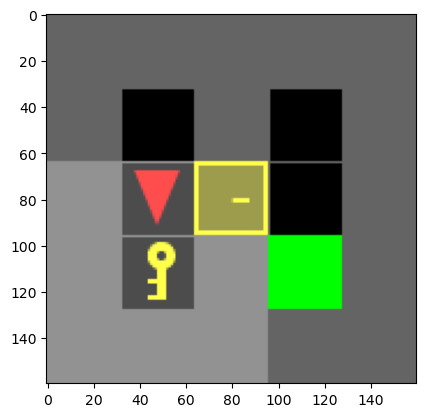

In [23]:
env = get_door_key_env(5)

In [37]:
PPO_agent = PPO(ACModel, env=env, args=Config(), seed=0)
smooth_rs, num_frames = PPO_agent.train()

plt.plot(num_frames, smooth_rs)

NotImplementedError: 